In [1]:
import os
import numpy as np
import pandas as pd
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
from hough import *
from conformal_map import *
from tqdm import tqdm

%matplotlib inline

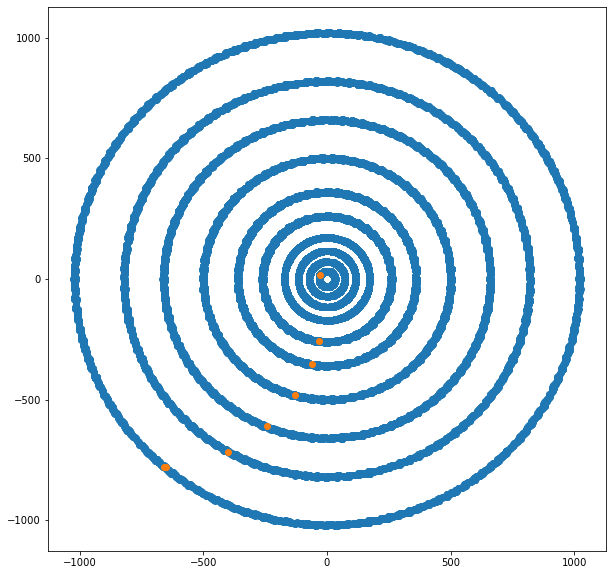

In [2]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
selected_indices = hits.index[cond].tolist()
selected_hits = hits.iloc[selected_indices]
selected_truth = truth.iloc[selected_indices]
trackId = selected_truth.particle_id.unique()[505]
track = selected_truth[selected_truth.particle_id == trackId]
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.plot(selected_hits.x, selected_hits.y, 'o')
ax.plot(track.tx, track.ty, 'o')
plt.show()

In [22]:
data = np.load("all.npz")
train_X = data['X']
train_y = data['y']
train_y_mag = data['y_mag']

data = np.load("all_2.npz")
train_X = np.vstack([train_X, data['X']])
train_y = np.vstack([train_y, data['y']])
train_y_mag = np.vstack([train_y_mag, data['y_mag']])

# Tackle the main problem of having the indices of tracks overflowing due to modulo operator when binning on theta

## Shift every hit to the "middle" (this gives approx 96% acc on test set)

Not sure how good it would be to shift every hit to the "middle" when dealing with multiple tracks

In [23]:
B = train_X.shape[1]
from tqdm import trange
for n in trange(train_X.shape[0]):
    first_index = np.argmax(train_X[n, :, 0])
    move_range = first_index - B / 2
    train_X[n] = np.roll(train_X[n], shift=-int(move_range), axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37412/37412 [00:01<00:00, 25108.50it/s]


### Show an example training image

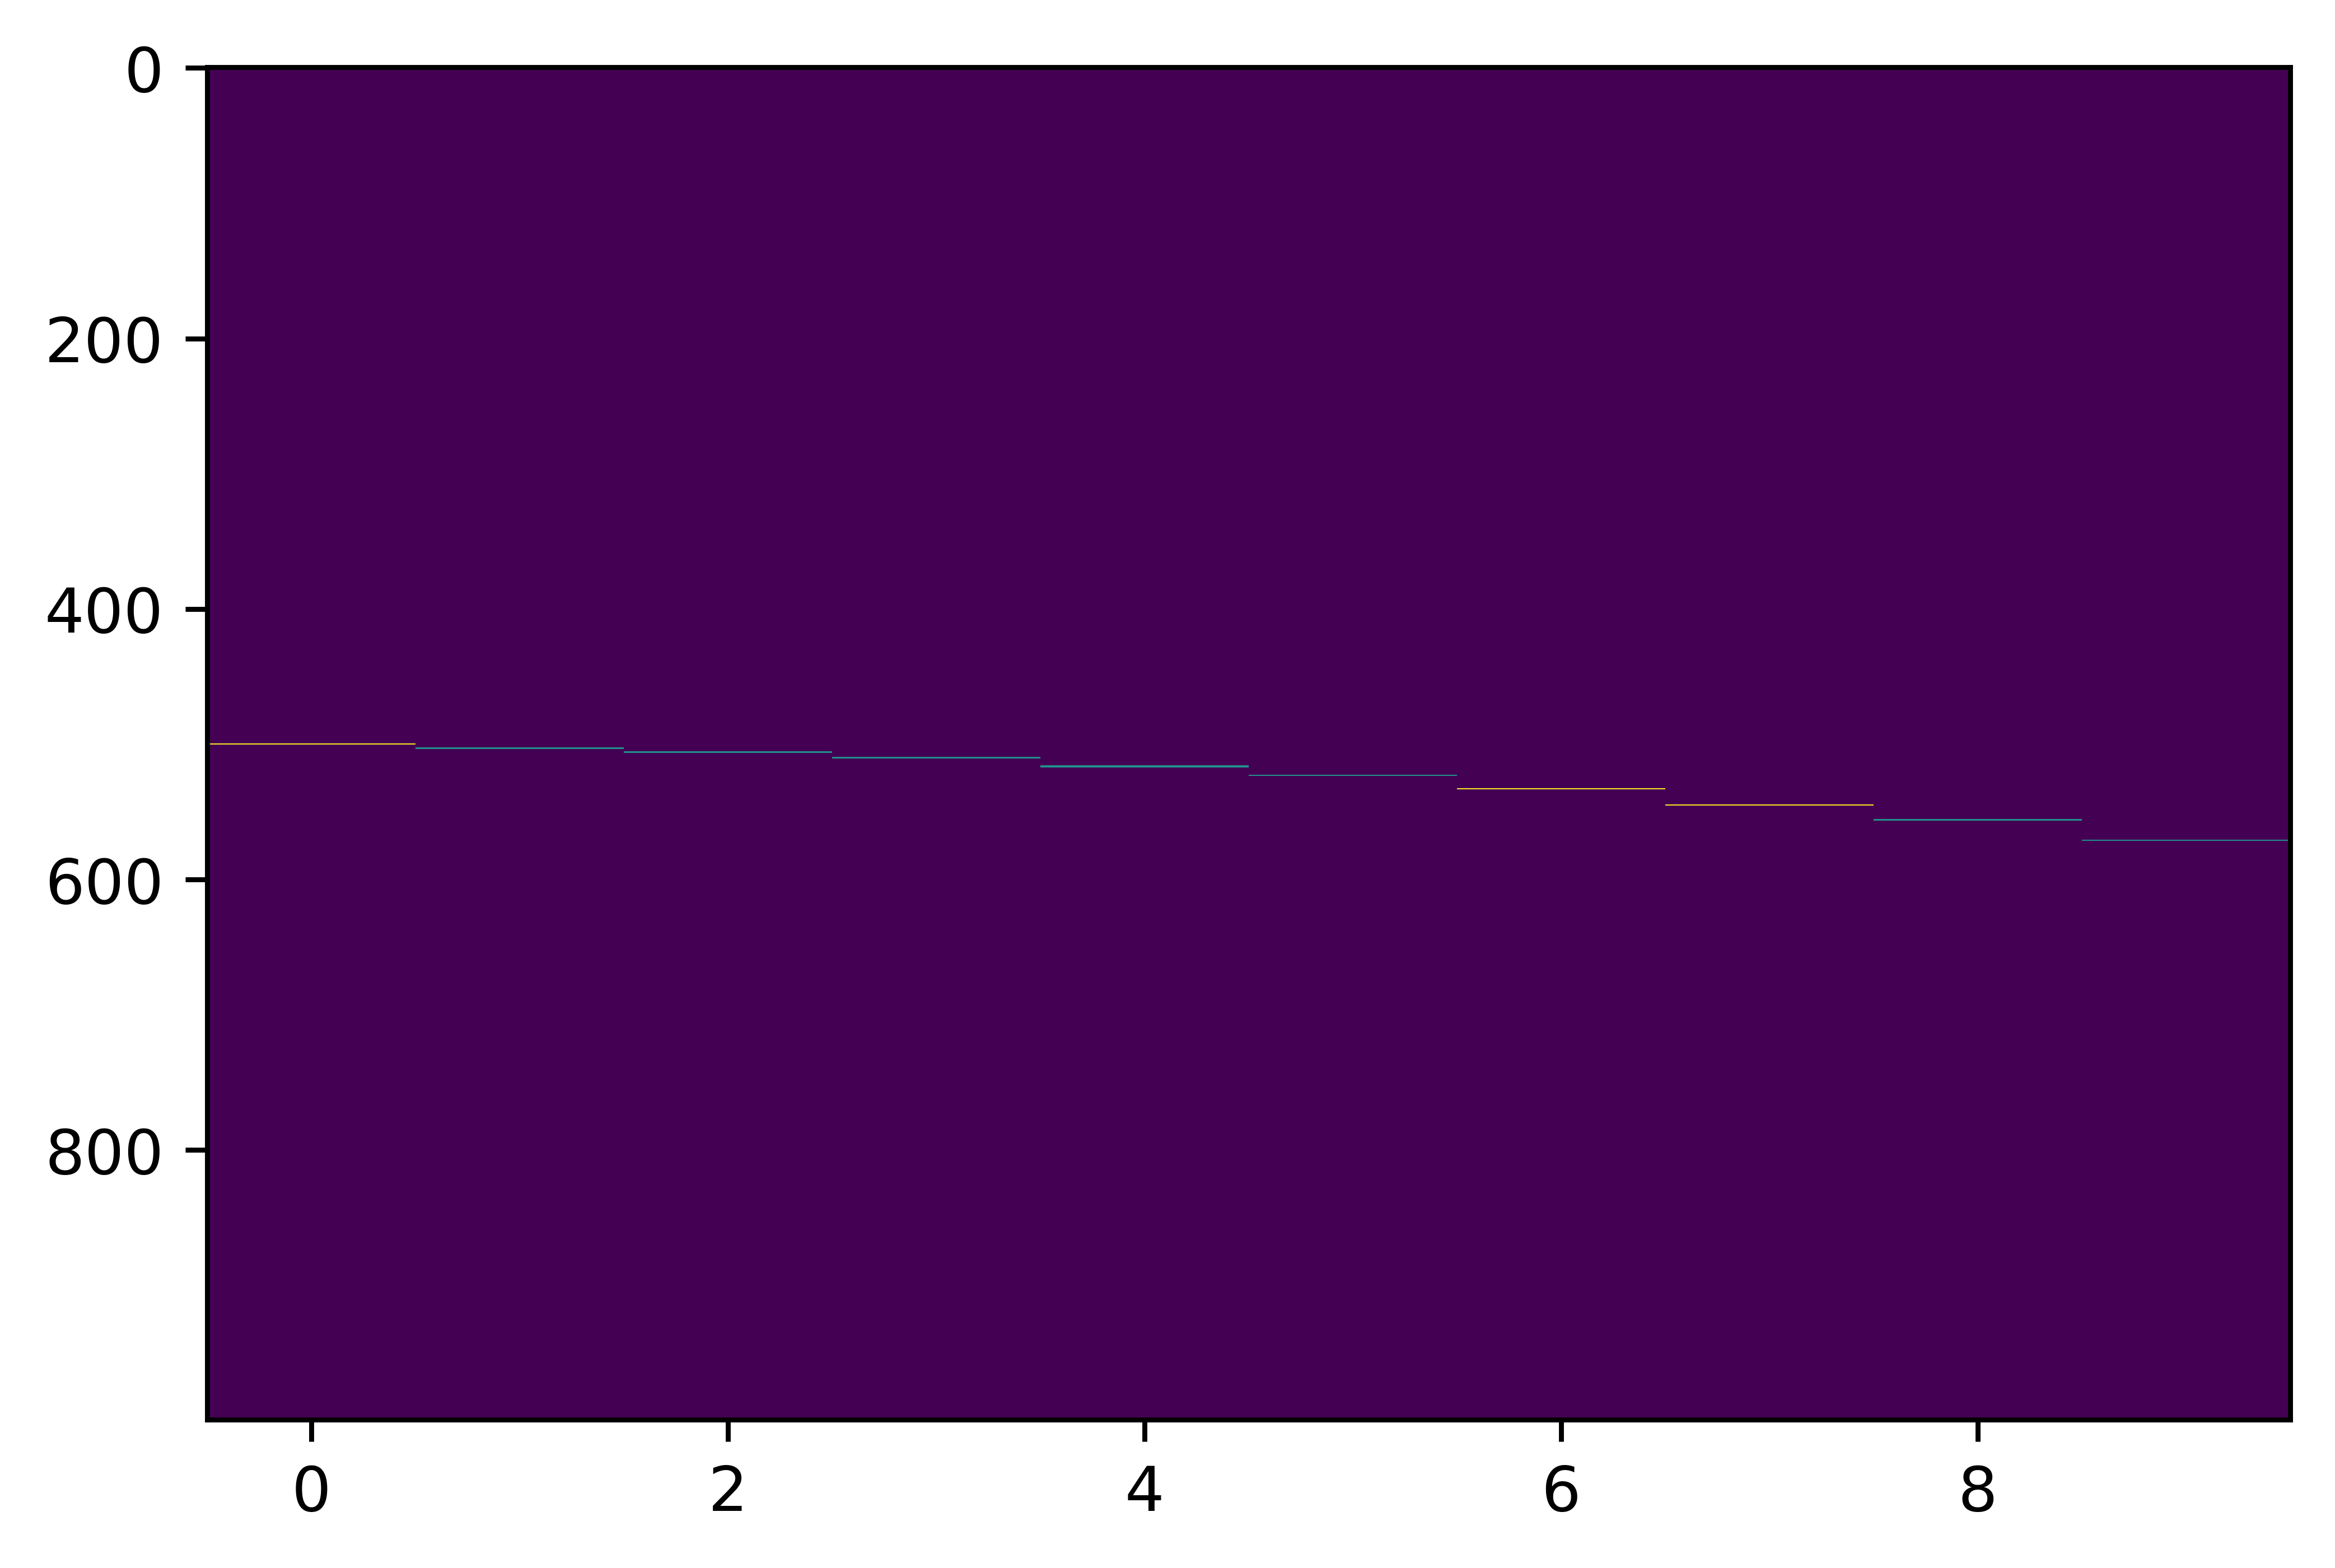

In [13]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 800
a = 100
plt.imshow(np.reshape(train_X[a], (B, 10)),aspect="auto")

### Split into training and test set

In [26]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y_mag, test_y_mag = train_test_split(train_X, train_y_mag, test_size=0.1)

In [27]:
print(train_X.shape, train_y_mag.shape)
print(test_X.shape, test_y_mag.shape)

(33670, 1000, 10, 1) (33670, 1)
(3742, 1000, 10, 1) (3742, 1)


In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras import layers
from keras import backend as K
from keras import regularizers
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [29]:
def build_model():
    model = keras.Sequential([
        layers.Conv2D(16, (3, 3), activation="relu", input_shape=(B, 10, 1)),
        layers.Conv2D(8, (3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(8, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(50, activation="relu"),
        layers.Dense(1)
    ])

    model.compile(loss='mae', optimizer="adam")
    return model

In [30]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 998, 8, 16)        160       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 996, 6, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 498, 3, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 496, 1, 8)         584       
_________________________________________________________________
flatten_3 (Flatten)          (None, 3968)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                198450    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [31]:
EPOCHS = 13
print(train_X.shape)
print(train_y.shape)
history = model.fit(train_X, train_y_mag, validation_split=0.1, epochs=EPOCHS) 

(33670, 1000, 10, 1)
(37412, 2)
Train on 30303 samples, validate on 3367 samples
Epoch 1/13
30303/30303 [==============================] - 112s 4ms/step - loss: 0.1219 - val_loss: 0.0757
Epoch 2/13
30303/30303 [==============================] - 14s 460us/step - loss: 0.0726 - val_loss: 0.0544
Epoch 3/13
30303/30303 [==============================] - 14s 459us/step - loss: 0.0635 - val_loss: 0.0512
Epoch 4/13
30303/30303 [==============================] - 15s 485us/step - loss: 0.0584 - val_loss: 0.0534
Epoch 5/13
30303/30303 [==============================] - 14s 468us/step - loss: 0.0561 - val_loss: 0.0527
Epoch 6/13
30303/30303 [==============================] - 14s 477us/step - loss: 0.0539 - val_loss: 0.0429
Epoch 7/13
30303/30303 [==============================] - 14s 468us/step - loss: 0.0529 - val_loss: 0.0423
Epoch 8/13
30303/30303 [==============================] - 14s 477us/step - loss: 0.0502 - val_loss: 0.0525
Epoch 9/13
30303/30303 [==============================] - 14s 45

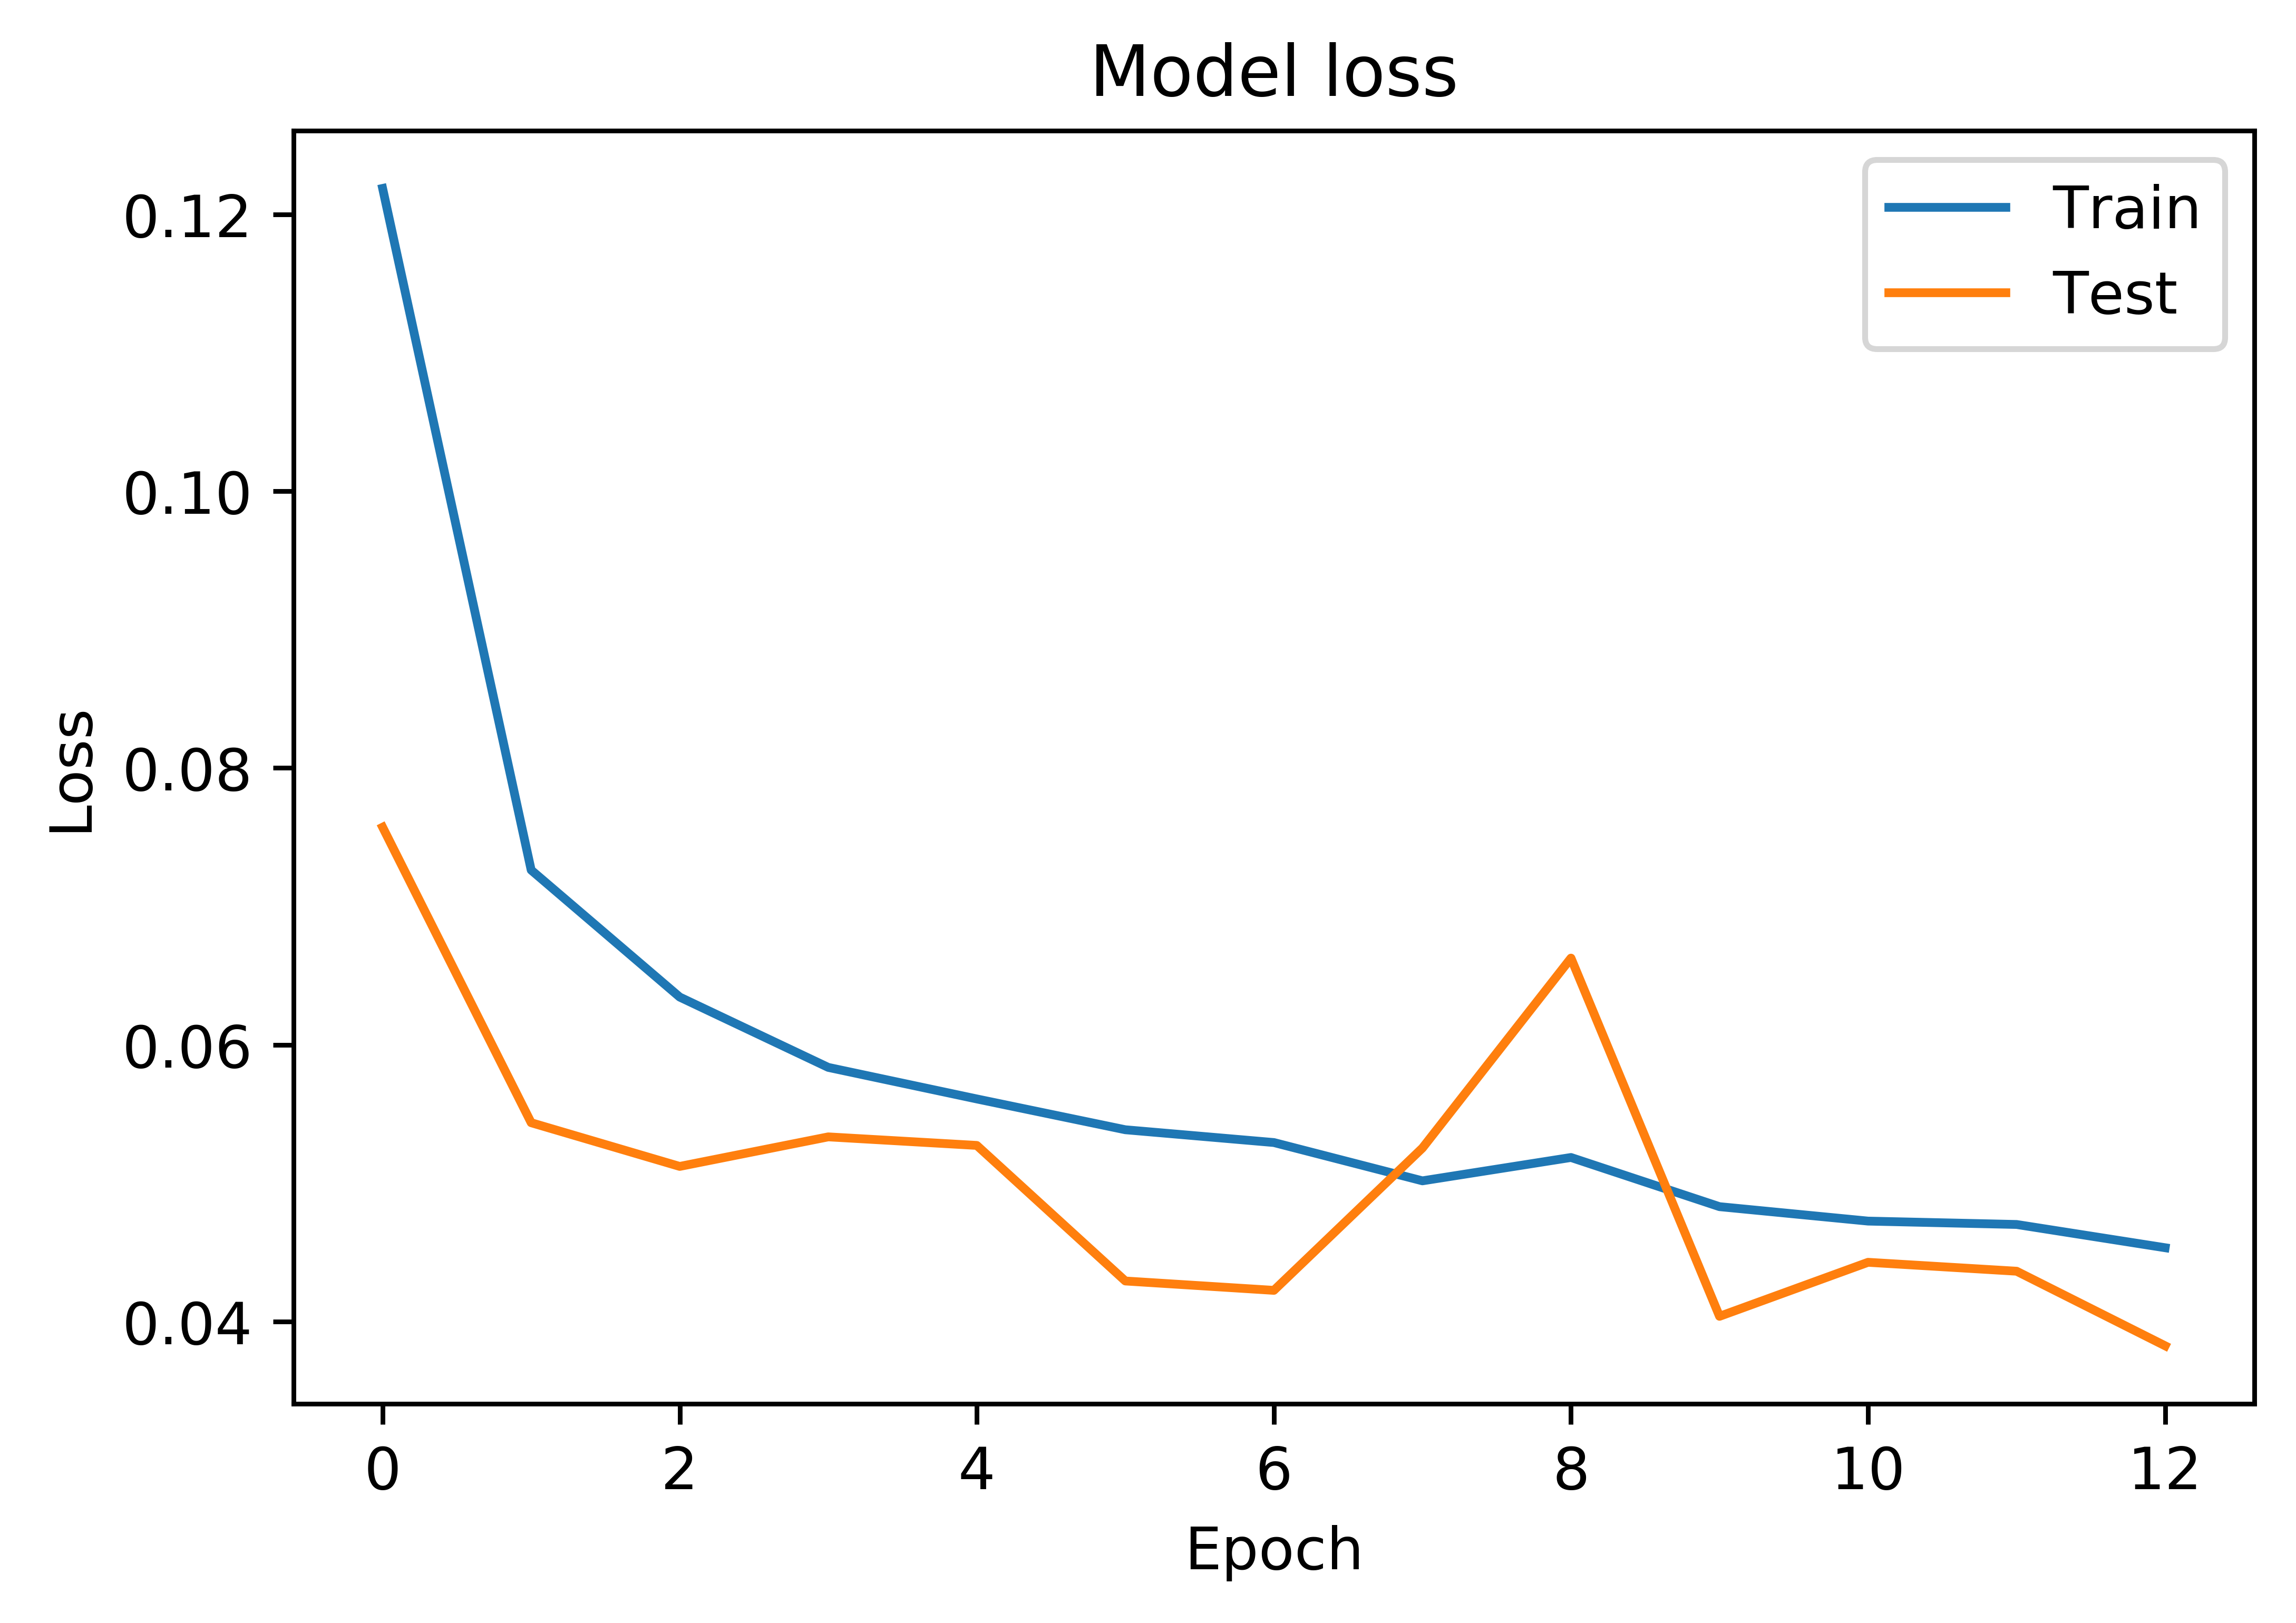

In [32]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [33]:
test_loss = model.evaluate(test_X, test_y_mag)
print(test_loss)

train_loss = model.evaluate(train_X, train_y_mag)
print(train_loss)

3742/3742 [==============================] - 1s 199us/step
0.06270431765399472
33670/33670 [==============================] - 6s 182us/step
0.038810829740799885


In [34]:
percentages = []
for i in range(len(test_X)):
    prediction = model.predict(np.reshape(test_X[i], (1, B, 10, 1)))
    percentages.append(abs((prediction - test_y_mag[i]) / test_y_mag[i]) * 100)
percentages = np.array(percentages)
print("Accuracy:", 100 - np.mean(percentages))

Accuracy: 96.04443159789142


In [ ]:
percentages = []
for i in range(len(train_X)):
    prediction = model.predict(np.reshape(train_X[i], (1, B, 10, 1)))
    percentages.append(abs((prediction - train_y_mag[i]) / train_y_mag[i]) * 100)
percentages = np.array(percentages)
print("Accuracy:", 100 - np.mean(percentages))